# COMP90084 Workshop Week 9 - VQE
Follows https://learn.qiskit.org/course/ch-applications/simulating-molecules-using-vqe and https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/03_vqe_simulation_with_noise.ipynb, and relevant Pennylane demos.
## Introduction<a id='introduction'></a>
In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. Thus, in 2014, Peruzzo *et al.* proposed VQE to estimate the ground state energy of a molecule using much shallower circuits. 

Formally stated, given a Hermitian matrix $H$ with an unknown minimum eigenvalue $\lambda_{min}$, associated with the eigenstate $|\psi_{min}\rangle$, VQE provides an estimate $\lambda_{\theta}$ bounding $\lambda_{min}$:

\begin{align*}
    \lambda_{min} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{align*}  

where $|\psi(\theta)\rangle$ is the eigenstate associated with $\lambda_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{min}\rangle$. The estimate is iteratively optimized by a classical controller changing the parameter $\theta$ minimizing the expectation value of $\langle \psi(\theta) |H|\psi(\theta) \rangle$.

## The Variational Method of Quantum Mechanics<a id='varmethod'></a>
### Mathematical Background<a id='backgroundmath'></a>

VQE is an application of the variational method of quantum mechanics. To better understand the variational method, some preliminary mathematical background is provided. An eigenvector, $|\psi_i\rangle$, of a matrix $A$ is invariant under transformation by $A$ up to a scalar multiplicative constant (the eigenvalue $\lambda_i$). That is,

\begin{align*}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{align*}

Furthermore, a matrix $H$ is Hermitian when it is equal to its own conjugate transpose.

\begin{align*}
    H = H^{\dagger}
\end{align*}

The spectral theorem states that the eigenvalues of a Hermitian matrix must be real. Thus, any eigenvalue of $H$ has the property that $\lambda_i = \lambda_i^*$. As any measurable quantity must be real, Hermitian matrices are suitable for describing the Hamiltonians of quantum systems. Moreover, $H$ may be expressed as

\begin{align*}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{align*}

where each $\lambda_i$ is the eigenvalue corresponding to the eigenvector $|\psi_i\rangle$. Furthermore, the expectation value of the observable $H$ on an arbitrary quantum state $|\psi\rangle$ is given by 

\begin{align}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{align}

Substituting $H$ with its representation as a weighted sum of its eigenvectors,

\begin{align}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}


The last equation demonstrates that the expectation value of an observable on any state can be expressed as a linear combination using the eigenvalues associated with $H$ as the weights. Moreover, each of the weights in the linear combination is greater than or equal to 0, as $| \langle \psi_i | \psi\rangle |^2 \ge 0$ and so it is clear that

\begin{align}
    \lambda_{min} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}

The above equation is known as the **variational method** (in some texts it is also known as the variational principle) [2]. It is important to note that this implies that the expectation value of any wave function will always be at least the minimum eigenvalue associated with $H$. Moreover, the expectation value of the eigenstate $|\psi_{min}\rangle$ is given by $\langle \psi_{min}|H|\psi_{min}\rangle = \langle \psi_{min}|\lambda_{min}|\psi_{min}\rangle = \lambda_{min}$. Thus, as expected, $\langle H \rangle_{\psi_{min}}=\lambda_{min}$.

### Bounding the Ground State<a id='groundstate'></a>
When the Hamiltonian of a system is described by the Hermitian matrix $H$ the ground state energy of that system, $E_{gs}$, is the smallest eigenvalue associated with $H$. By arbitrarily selecting a wave function $|\psi \rangle$ (called an *ansatz*) as an initial guess approximating $|\psi_{min}\rangle$, calculating its expectation value, $\langle H \rangle_{\psi}$, and iteratively updating the wave function, arbitrarily tight bounds on the ground state energy of a Hamiltonian may be obtained. 


## The Variational Quantum Eigensolver<a id='vqe'></a>
### Variational Forms<a id='varforms'></a>
A systematic approach to varying the ansatz is required to implement the variational method on a quantum computer. VQE does so through the use of a parameterized circuit with a fixed form. Such a circuit is often called a *variational form*, and its action may be represented by the linear transformation $U(\theta)$. A variational form is applied to a starting state $|\psi\rangle$ (such as the vacuum state $|0\rangle$, or the Hartree Fock state) and generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{min}\rangle$ (where 'closeness' is characterized by either state fidelity, or Manhattan distance) although in practice, useful bounds on $E_{gs}$ can be obtained even if this is not the case.

Moreover, a fixed variational form with a polynomial number of parameters can only generate transformations to a polynomially sized subspace of all the states in an exponentially sized Hilbert space. Consequently, various variational forms exist. Some, such as Ry and RyRz are heuristically designed, without consideration of the target domain. Others, such as UCCSD, utilize domain specific knowledge to generate close approximations based on the problem's structure. The structure of common variational forms is discussed in greater depth later in this document. 

### Simple Variational Forms<a id='simplevarform'></a>
When constructing a variational form we must balance two opposing goals. Ideally, our $n$ qubit variational form would be able to generate any possible state $|\psi\rangle$ where $|\psi\rangle \in \mathbb{C}^N$ and $N=2^n$. However, we would like the variational form to use as few parameters as possible. Here, we aim to give intuition for the construction of variational forms satisfying our first goal, while disregarding the second goal for the sake of simplicity. 

Consider the case where $n=1$. The U3 gate takes three parameters, $\theta, \phi$ and $\lambda$, and represents the following transformation:

$$
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align}
$$

Up to a global phase, any possible single qubit transformation may be implemented by appropriately setting these parameters. Consequently, for the single qubit case, a variational form capable of generating any possible state is given by the circuit:

![image1](https://qiskit.org/textbook/ch-applications/images/U3_var_form.png)


Moreover, this universal 'variational form' only has 3 parameters and thus can be efficiently optimized. It is worth emphasizing that the ability to generate an arbitrary state ensures that during the optimization process, the variational form does not limit the set of attainable states over which the expectation value of $H$ can be taken. Ideally, this ensures that the minimum expectation value is limited only by the capabilities of the classical optimizer. 

A less trivial universal variational form may be derived for the 2 qubit case, where two body interactions, and thus entanglement, must be considered to achieve universality. Based on the work presented by *Shende et al.* [3] the following is an example of a universal parameterized 2 qubit circuit:

![image2](https://qiskit.org/textbook/ch-applications/images/two_qubit_var_form.png)
     
Allow the transformation performed by the above circuit to be represented by $U(\theta)$. When optimized variationally, the expectation value of $H$ is minimized when $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{min}\rangle$. By formulation, $U(\theta)$ may produce a transformation to any possible state, and so this variational form may obtain an arbitrarily tight bound on two qubit ground state energies, only limited by the capabilities of the classical optimizer.

## VQE in Qiskit


In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

In [2]:
# define the Hamiltonian
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In the assignment questions, your parameters in the Hamiltonian need to follow https://journals.aps.org/prx/supplemental/10.1103/PhysRevX.8.011021/Supplementary.pdf. For your convenience, we'll provide the coefficients here:

```
distance_and_coeffs = np.array([
    [0.05,  1.00777E+01,	-1.05533E+00,	1.55708E-01,	-1.05533E+00,	1.39333E-02],
    [0.10,	4.75665E+00,	-1.02731E+00,	1.56170E-01,	-1.02731E+00,	1.38667E-02],
    [0.15,	2.94817E+00,	-9.84234E-01,	1.56930E-01,	-9.84234E-01,	1.37610E-02],
    [0.20,	2.01153E+00,	-9.30489E-01,	1.57973E-01,	-9.30489E-01,	1.36238E-02],
    [0.25,	1.42283E+00,	-8.70646E-01,	1.59277E-01,	-8.70646E-01,	1.34635E-02],
    [0.30,	1.01018E+00,	-8.08649E-01,	1.60818E-01,	-8.08649E-01,	1.32880E-02],
    [0.35,	7.01273E-01,	-7.47416E-01,	1.62573E-01,	-7.47416E-01,	1.31036E-02],
    [0.40,	4.60364E-01,	-6.88819E-01,	1.64515E-01,	-6.88819E-01,	1.29140E-02],
    [0.45,	2.67547E-01,	-6.33890E-01,	1.66621E-01,	-6.33890E-01,	1.27192E-02],
    [0.50,	1.10647E-01,	-5.83080E-01,	1.68870E-01,	-5.83080E-01,	1.25165E-02],
    [0.55,	-1.83734E-02,	-5.36489E-01,	1.71244E-01,	-5.36489E-01,	1.23003E-02],
    [0.65,	-2.13932E-01,	-4.55433E-01,	1.76318E-01,	-4.55433E-01,	1.18019E-02],
    [0.75,	-3.49833E-01,	-3.88748E-01,	1.81771E-01,	-3.88748E-01,	1.11772E-02],
    [0.85,	-4.45424E-01,	-3.33747E-01,	1.87562E-01,    -3.33747E-01,	1.04061E-02],
    [0.95,	-5.13548E-01,	-2.87796E-01,	1.93650E-01,	-2.87796E-01,	9.50345E-03],
    [1.05,	-5.62600E-01,	-2.48783E-01,	1.99984E-01,	-2.48783E-01,	8.50998E-03],
    [1.15,	-5.97973E-01,	-2.15234E-01,	2.06495E-01,	-2.15234E-01,	7.47722E-03],
    [1.25,	-6.23223E-01,	-1.86173E-01,	2.13102E-01,	-1.86173E-01,	6.45563E-03],
    [1.35,	-6.40837E-01,	-1.60926E-01,	2.19727E-01,	-1.60926E-01,	5.48623E-03],
    [1.45,	-6.52661E-01,	-1.38977E-01,	2.26294E-01,	-1.38977E-01,	4.59760E-03],
    [1.55,	-6.60117E-01,	-1.19894E-01,	2.32740E-01,	-1.19894E-01,	3.80558E-03],
    [1.65,	-6.64309E-01,	-1.03305E-01,	2.39014E-01,	-1.03305E-01,	3.11545E-03],
    [1.75,	-6.66092E-01,	-8.88906E-02,	2.45075E-01,	-8.88906E-02,	2.52480E-03],
    [1.85,	-6.66126E-01,	-7.63712E-02,	2.50896E-01,	-7.63712E-02,	2.02647E-03],
    [1.95,	-6.64916E-01,	-6.55065E-02,	2.56458E-01,	-6.55065E-02,	1.61100E-03],
    [2.05,	-6.62844E-01,	-5.60866E-02,	2.61750E-01,	-5.60866E-02,	1.26812E-03],
    [2.15,	-6.60199E-01,	-4.79275E-02,	2.66768E-01,	-4.79275E-02,	9.88000E-04],
    [2.25,	-6.57196E-01,	-4.08672E-02,	2.71512E-01,	-4.08672E-02,	7.61425E-04],
    [2.35,	-6.53992E-01,	-3.47636E-02,	2.75986E-01,	-3.47636E-02,	5.80225E-04],
    [2.45,	-6.50702E-01,	-2.94924E-02,	2.80199E-01,	-2.94924E-02,	4.36875E-04],
    [2.55,	-6.47408E-01,	-2.49459E-02,	2.84160E-01,	-2.49459E-02,	3.25025E-04],
    [2.65,	-6.44165E-01,	-2.10309E-02,	2.87881E-01,	-2.10309E-02,	2.38800E-04],
    [2.75,	-6.41011E-01,	-1.76672E-02,	2.91376E-01,	-1.76672E-02,	1.73300E-04],
    [2.85,	-6.37971E-01,	-1.47853E-02,	2.94658E-01,	-1.47853E-02,	1.24200E-04],
    [2.95,	-6.35058E-01,	-1.23246E-02,	2.97741E-01,	-1.23246E-02,	8.78750E-05],
    [3.05,	-6.32279E-01,	-1.02318E-02,	3.00638E-01,	-1.02317E-02,	6.14500E-05],
    [3.15,	-6.29635E-01,	-8.45958E-03,	3.03362E-01,	-8.45958E-03,	4.24250E-05],
    [3.25,	-6.27126E-01,	-6.96585E-03,	3.05927E-01,	-6.96585E-03,	2.89500E-05],
    [3.35,	-6.24746E-01,	-5.71280E-03,	3.08344E-01,	-5.71280E-03,	1.95500E-05],
    [3.45,	-6.22491E-01,	-4.66670E-03,	3.10625E-01,	-4.66670E-03,	1.30500E-05],
    [3.55,	-6.20353E-01,	-3.79743E-03,	3.12780E-01,	-3.79743E-03,	8.57500E-06],
    [3.65,	-6.18325E-01,	-3.07840E-03,	3.14819E-01,	-3.07840E-03,	5.60000E-06],
    [3.75,	-6.16401E-01,	-2.48625E-03,	3.16750E-01,	-2.48625E-03,	3.60000E-06],
    [3.85,	-6.14575E-01,	-2.00063E-03,	3.18581E-01,	-2.00062E-03,	2.27500E-06],
    [3.95,	-6.12839E-01,	-1.60393E-03,	3.20320E-01,	-1.60392E-03,	1.42500E-06]
])
```
as well as the function which takes the coefficients as input arguments and returns the Hamiltonian:
```
def hamiltonianH2(coeff_I, coeff_Z1, coeff_X1X2, coeffZ_2, coeff_Z1Z2):
    return coeff_I*(I^I) + coeff_Z1*(I^Z) + coeffZ_2*(Z^I) + coeff_X1X2*(X^X) + coeff_Z1Z2*(Z^Z)
```


As the $H_2$ problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value so we can compare later the results.

In [3]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


Then run VQE on the simulator

VQE on Aer qasm simulator (no noise): -1.85332
Delta from reference energy value is 0.00395


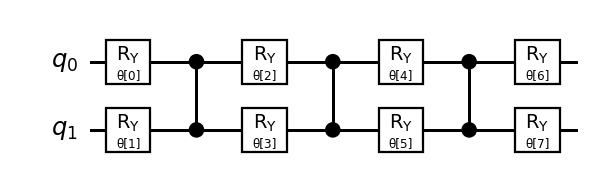

In [4]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz') # For the assignment, you'll need to use the ansatz provided in the specs
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')
ansatz.decompose().draw('mpl', style='bw', scale = 1.5)

Text(0.5, 1.0, 'Convergence with no noise')

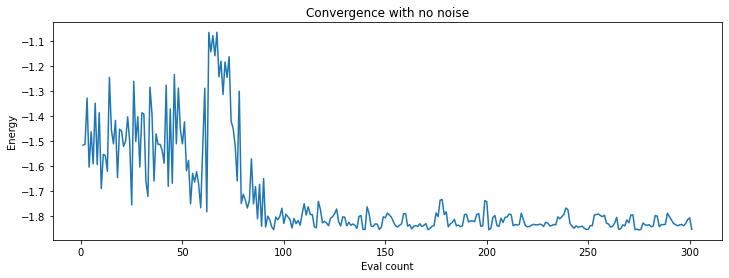

In [5]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

## VQE in Pennylane

In [6]:
from pennylane import numpy as np

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [7]:
import pennylane as qml

H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.2427450126096215) [Z2]
+ (-0.24274501260962145) [Z3]
+ (-0.04207255194725573) [I0]
+ (0.17771358229079076) [Z1]
+ (0.1777135822907908) [Z0]
+ (0.12293330449305753) [Z0 Z2]
+ (0.12293330449305753) [Z1 Z3]
+ (0.1676833885561007) [Z0 Z3]
+ (0.1676833885561007) [Z1 Z2]
+ (0.17059759276839584) [Z0 Z1]
+ (0.17627661394197264) [Z2 Z3]
+ (-0.04475008406304316) [Y0 Y1 X2 X3]
+ (-0.04475008406304316) [X0 X1 Y2 Y3]
+ (0.04475008406304316) [Y0 X1 X2 Y3]
+ (0.04475008406304316) [X0 Y1 Y2 X3]


In [8]:
dev = qml.device("default.qubit", wires=qubits)

Next, we need to define the quantum circuit that prepares the trial
state of the molecule. We want to prepare states of the form,

$$\vert \Psi(\theta) \rangle = \cos(\theta/2)~|1100\rangle -\sin(\theta/2)~|0011\rangle,$$

where $\theta$ is the variational parameter to be optimized in order to
find the best approximation to the true ground state. In the
Jordan-Wigner encoding, the first term $|1100\rangle$ represents the
[Hartree-Fock (HF)
state](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) where
the two electrons in the molecule occupy the lowest-energy orbitals. The
second term $|0011\rangle$ encodes a double excitation of the HF state
where the two particles are excited from qubits 0, 1 to 2, 3.

The quantum circuit to prepare the trial state
$\vert \Psi(\theta) \rangle$ is schematically illustrated in the figure
below.



![](https://pennylane.ai/qml/_images/sketch_circuit.png)



In this figure, the gate $G^{(2)}$ corresponds to the
`pennylane.DoubleExcitation`
operation, implemented in PennyLane as a [Givens
rotation](https://en.wikipedia.org/wiki/Givens_rotation), which couples
the four-qubit states $\vert 1100 \rangle$ and $\vert 0011 \rangle$. For
more details on how to use the excitation operations to build quantum
circuits for quantum chemistry applications see the tutorial
https://pennylane.ai/qml/demos/tutorial_givens_rotations.html.

Implementing the circuit above using PennyLane is straightforward.
First, we use the `hf_state()` function to
generate the vector representing the Hartree-Fock state.


In [9]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [10]:
# define the ansatz
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
# define the cost function
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [11]:
# optimization
step_size = 0.4
# a basic gradient-descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=step_size)
# initialize the circuit parameter
theta = np.array(0.0, requires_grad=True)
# carry out the optimization
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


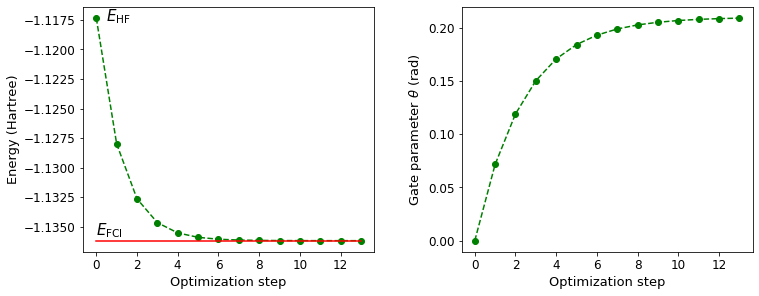

In [12]:
# plot the optimization process
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In this case, the VQE algorithm converges after thirteen iterations. The
optimal value of the circuit parameter $\theta^* = 0.208$ defines the
state

$$\vert \Psi(\theta^*) \rangle = 0.994~\vert 1100 \rangle - 0.104~\vert 0011 \rangle,$$

which is precisely the ground state of the $\mathrm{H}_2$ molecule in a
minimal basis set approximation.